# Results S-ARIMA modelling 

In [2]:
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

In [3]:
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(8, 8))
plt.rc("font", size=13)

## Import training and test data of the UK smart meter data

In [4]:
import os
# print path
print(os.getcwd())

/Users/saschimi/Documents/github/ml4gd-project-group-3/arima


In [5]:
import pickle

filepath = "../uk-smart-meter-aggregated/"
filename = "df_agg_drive.pkl"
# load pickle file
with open(filepath+filename, "rb") as f:
    df = pickle.load(f)
df.head()

,2,3,4,6,7,8,9,10,11,12,...,5535,5536,5537,5538,5541,5549,5550,5551,5557,5564
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_normalised = df.copy()
# Get the min and max of all rows
min = df_normalised.min(axis=1).min(axis=0)
max = df_normalised.max(axis=1).max(axis=0)
print("min: ", min, "max: ", max)
df_normalised = (df_normalised - min)/(max - min)

min:  0.0 max:  20.8689995


array([<Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>], dtype=object)

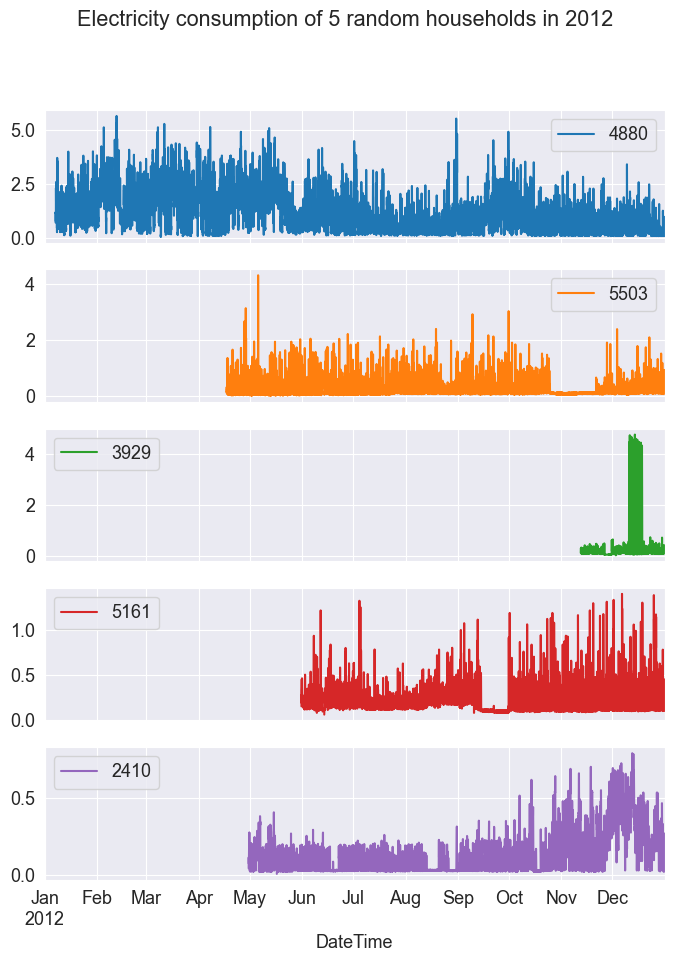

In [7]:
# Take five random households and create a time series plot of their electricity consumption
seed = 1985
np.random.seed(seed)
random_households = np.random.choice(df.columns, 5)
# Rows for DateTime = 2012-01-01 00:00:00 to 2012-12-31 23:00:00
df_range = df[(df.index >= "2012-01-01 00:00:00") & (df.index <= "2012-12-31 23:00:00")]
five_households = df_range[random_households]
five_households.plot(subplots=True, figsize=(8, 10), title="Electricity consumption of 5 random households in 2012")

In [8]:
print(five_households.describe())
print(five_households)

              4880         5503         3929         5161         2410
count  8630.000000  6161.000000  1190.000000  5124.000000  5849.000000
mean      1.131299     0.252373     0.543303     0.231334     0.127354
std       0.911612     0.306568     1.117999     0.162282     0.136685
min       0.081000     0.001000     0.042000     0.056000     0.007000
25%       0.386250     0.096000     0.104000     0.120000     0.030000
50%       0.870000     0.139000     0.183000     0.176000     0.069000
75%       1.652000     0.273000     0.288000     0.295000     0.164000
max       5.626000     4.301000     4.759000     1.407000     0.787000
                      4880   5503   3929   5161   2410
DateTime                                              
2012-01-01 00:00:00    NaN    NaN    NaN    NaN    NaN
2012-01-01 01:00:00    NaN    NaN    NaN    NaN    NaN
2012-01-01 02:00:00    NaN    NaN    NaN    NaN    NaN
2012-01-01 03:00:00    NaN    NaN    NaN    NaN    NaN
2012-01-01 04:00:00    NaN    N

## Split year into training and validation set
Use 1st of October to start the validation set.

In [13]:
# Split data into training and testing sets
train_end = np.argmin(five_households.index < "2012-10-01 00:00:00")
val_start = train_end + 1
train_end

6576

In [15]:
print("Sizes of training and validation sets:", train_end, len(five_households) - val_start)


Sizes of training and validation sets: 6576 2207


## Create ARIMA model for the first household

array([<Axes: xlabel='DateTime'>], dtype=object)

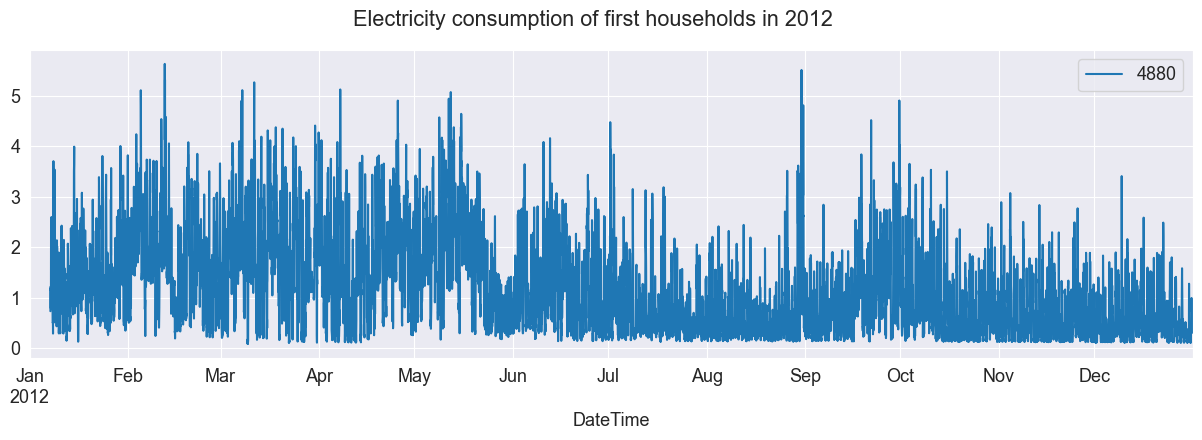

In [16]:
# Graph data
five_households.iloc[:, 0:1].plot(subplots=True, figsize=(15,4), title='Electricity consumption of first households in 2012')

In [67]:
# Graph data
five_households.iloc[:, 0:1].plot(subplots=True, figsize=(15,4), title='Electricity consumption of first households in 2012', xlim=["2012-02-01", "2012-02-07"])

AttributeError: 'DataFrame' object has no attribute 'scatter'

## Analyse seasonality for the first household

In [17]:
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

# Should be imported
def impute_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """Fill missing values in the dataframe with the last known value of the timeseries. If the previous value is missing, fill with the next known value.

        Args:
        df (pd.DataFrame): 1D timeseries given as a pandas dataframe with the values in the field specified by value_axis.
    """
    # Find last value that is not NaN or zero before a value that is NaN or zero
    df.replace(0, np.nan, inplace=True)
    df.ffill(inplace=True, axis=0)
    df.bfill(inplace=True, axis=0)
    return df


## Analyse seasonality and select the seasonality that is more prominent
The SARIMAX model can only handle single seasonality, this means, we need to select one period.

**Note**: We need to do data imputation because the MSTL seasonality detection cannot handle `NaN` values in the data.

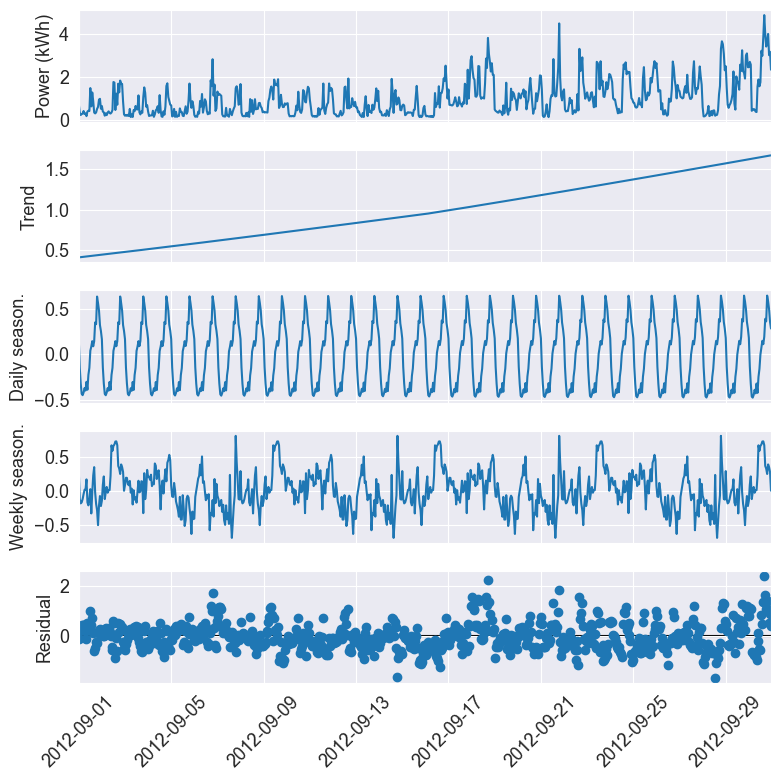

In [83]:
mstl = MSTL(
    impute_missing_values(five_households.iloc[train_end-720:train_end, 0:1]),
    periods=[24, 24 * 7],  # The periods and windows must be the same length and will correspond to one another.
    windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
    iterate=3,
    stl_kwargs={
                "trend":1001, # Setting this large will force the trend to be smoother.
                "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
               }
)
res = mstl.fit()
fig = res.plot()
ax = fig.get_axes()
# Access subplots y labels
ax[0].set_title("")
ax[0].set_ylabel("Power (kWh)")
ax[1].set_ylabel("Trend")
ax[2].set_ylabel("Daily season.")
ax[3].set_ylabel("Weekly season.")
ax[4].set_ylabel("Residual")
ax[4].tick_params(axis='x', labelrotation=45)
fig.tight_layout()
fig.savefig("../figures/mstl_decomposition.pdf")

As we can see, the daily seasonality `24 h` follows a periodic pattern better than the weekly one. Hence, we select the daily seasonality for the model selection scheme in the next section.

## Predict with the MSTL model

In [159]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

order = (2, 1, 2)
first_household = impute_missing_values(five_households.iloc[:train_end, 0:1]).copy(deep=True)
stlf = STLForecast(first_household, ARIMA, model_kwargs=dict(order=order, trend="t"))
stlf_res = stlf.fit()

In [161]:
print(stlf_res.summary())


                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                 6576
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3734.181
Date:                Mon, 17 Jun 2024   AIC                           7480.362
Time:                        16:41:20   BIC                           7521.108
Sample:                    01-01-2012   HQIC                          7494.446
                         - 09-30-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0001      0.000      0.332      0.740      -0.001       0.001
ar.L1          1.2239      0.109     11.209      0.000       1.010       1.438
ar.L2         -0.3343      0.079     -4.255      0.0

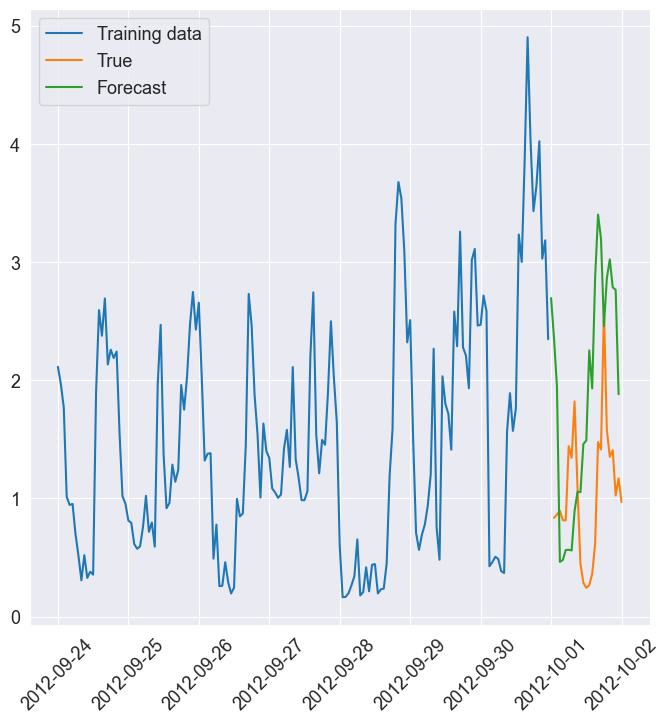

In [160]:
nforecast = 24
forecast = stlf_res.forecast(nforecast)
# predict = stlf_res.get_forecast(end=6600)
# predict_ci = predict.conf_int(alpha=0.5)

fig, ax = plt.subplots(1,1)
ax.plot(first_household[-nforecast*7:], label="Training data")
ax.plot(five_households.iloc[train_end+1:train_end+25, 0:1], label="True")
ax.plot(forecast, label="Forecast")
# ax.fill_between(predict_ci.index[-nforecast*7:], predict_ci.iloc[-nforecast*7:, 0], predict_ci.iloc[-nforecast*7:, 1], alpha=0.15)
plt.legend()
ax.tick_params(axis='x', labelrotation=45)
fig.savefig(f"../figures/stl_{order}_.pdf")

## Fit SARIMAX models with single seasonality of 24h for all five households

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52354D-01    |proj g|=  7.06605D-02


 This problem is unconstrained.



At iterate    5    f=  8.46300D-01    |proj g|=  4.37284D-02

At iterate   10    f=  8.34717D-01    |proj g|=  1.05662D+00

At iterate   15    f=  8.08270D-01    |proj g|=  1.05013D+01

At iterate   20    f=  8.05022D-01    |proj g|=  1.27245D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     49      1     0     0   6.732D-02   8.050D-01
  F =  0.80502146340639769     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


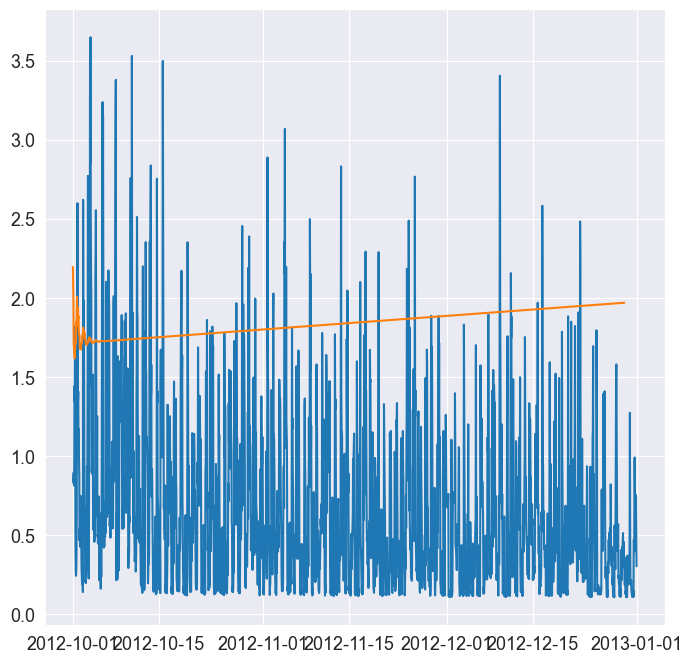

In [47]:
first_household = impute_missing_values(five_households.iloc[:, 0:1])
first_household.index.freq = "h"


In [50]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(first_household)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -7.076971547653369
p-value: 4.774104587414267e-10


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70107D+00    |proj g|=  8.71676D+00


 This problem is unconstrained.



At iterate    5    f=  1.02237D+00    |proj g|=  3.48334D-01

At iterate   10    f=  8.17021D-01    |proj g|=  7.60377D-02

At iterate   15    f=  8.05474D-01    |proj g|=  9.45383D-02

At iterate   20    f=  7.97156D-01    |proj g|=  4.51212D-02

At iterate   25    f=  7.88670D-01    |proj g|=  8.52580D-02

At iterate   30    f=  7.84557D-01    |proj g|=  7.38085D-02

At iterate   35    f=  7.83278D-01    |proj g|=  1.50892D-01

At iterate   40    f=  7.81027D-01    |proj g|=  1.19809D-01

At iterate   45    f=  7.80068D-01    |proj g|=  1.19861D+00


/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.79782D-01    |proj g|=  8.40198D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   8.402D-01   7.798D-01
  F =  0.77978240498457441     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


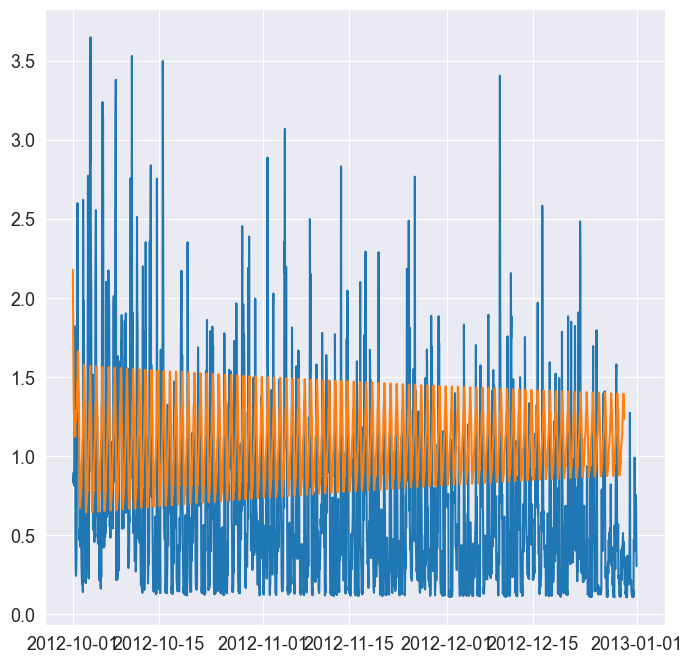

In [51]:
seasonal_order = (1, 0, 1, 24)
sarimax = sm.tsa.statespace.SARIMAX(first_household.iloc[0:train_end],
                                    trend="c",
                                    order=(2,0,1),
                                    seasonal_order=seasonal_order,
                                    enforce_invertibility=False,
                                    freq="h")
sarimax_res = sarimax.fit()

forecast = sarimax_res.forecast(720*3)
plt.plot(first_household[train_end:])
plt.plot(forecast)

In [52]:
print(sarimax_res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               4880   No. Observations:                 6576
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood               -5127.849
Date:                            Mon, 17 Jun 2024   AIC                          10269.698
Time:                                    14:21:20   BIC                          10317.236
Sample:                                01-01-2012   HQIC                         10286.131
                                     - 09-30-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      2.485      0.013       0.000       0.001
ar.L1          1.2894      0.054   

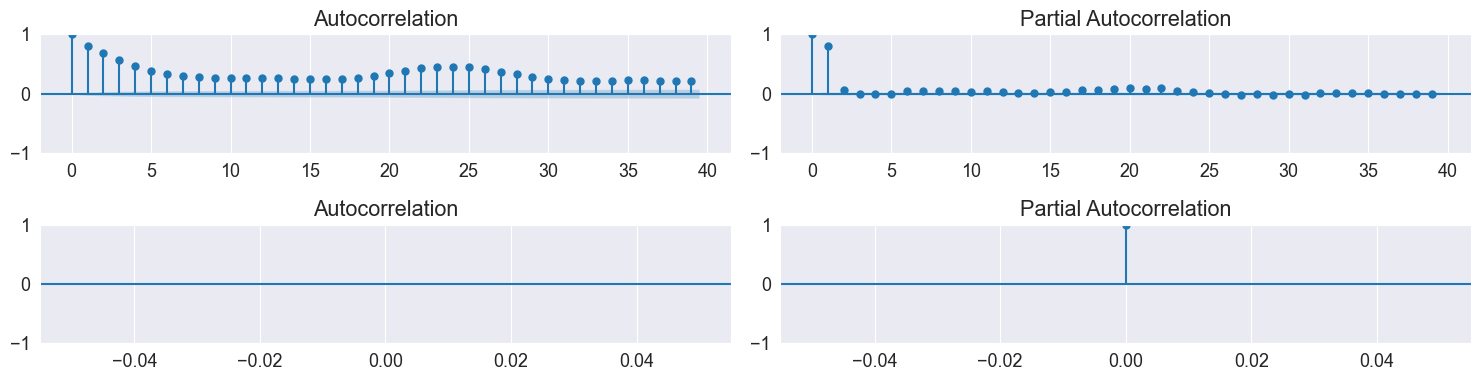

In [180]:
# Graph data
fig, axes = plt.subplots(2, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(first_household, ax=axes[0, 0])
fig = sm.graphics.tsa.plot_pacf(first_household, ax=axes[0, 1])

fig = sm.graphics.tsa.plot_acf(first_household.diff(), ax=axes[1,0])
fig = sm.graphics.tsa.plot_pacf(first_household.diff(), ax=axes[1, 1])
fig.tight_layout()

fig.savefig("../figures/acf_pacf.pdf")


In [53]:
import warnings

warnings.simplefilter('ignore')
def arima_aic(data, aic_full):
    """Train 6 times 6 ARIMA models with different p and q values and store the Akaike information criterion values in the dataframe passed as an argument.

    Args:
        data (_type_): Time series data to train the ARIMA models on.
        aic_full (_type_): DataFrame to store the AIC values of the ARIMA models.
    """
    # Based on prior analysis, we know that the seasonality is 24 hours
    seasonal_order = (1,1,0,24) # (Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)
    # Iterate over all ARMA(p,q) models with p,q in [0,6]
    for p in range(6):
        for q in range(6):
            # Baseline model does not have any AR or MA terms
            if p == 0 and q == 0:
                continue

            # Estimate the model with no missing datapoints
            mod = sm.tsa.statespace.SARIMAX(impute_missing_values(data),
                                            order=(p,0,q),
                                            seasonal_order=seasonal_order,
                                            enforce_invertibility=False)
            try:
                res = mod.fit(disp=False)
                aic_full.iloc[p,q] = res.aic
            except:
                aic_full.iloc[p,q] = np.nan


In [54]:
warnings.simplefilter('ignore')
aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
arima_aic(first_household.iloc[:train_end], aic_full)
# Find the ARMA(p,q) model with the lowest AIC
print("Household", 1)
print(aic_full)
p_full, q_full = np.unravel_index(aic_full.values.argmin(), aic_full.shape)
print("Best ARMA(p,q) model:", p_full, q_full)

Household 1
              0             1             2             3             4  \
0      0.000000  14085.778276  13227.567390  12922.953546  12733.482595   
1  12614.809286  12592.344786  12592.842519  12594.639687  12596.420760   
2  12593.581797  12592.627668  12591.525009  12593.287138  12594.833351   
3  12593.097490  12591.984510  12594.663896  12595.202621  12598.250984   
4  12594.575697  12594.459471  12596.000144  12593.666518  12431.786440   
5  12595.842217  12596.063679  12599.677137  12596.797933  12594.882070   

              5  
0  12670.044565  
1  12591.791162  
2  12591.067420  
3  12592.695109  
4  12593.745538  
5  12595.829994  
Best ARMA(p,q) model: 0 0


In [184]:
first_household = impute_missing_values(five_households.iloc[:train_end, 0:1]).copy(deep=True)
order = (1,1,1)
seasonal_order = (1, 1, 1, 24)
warnings.simplefilter('ignore')
sarimax = sm.tsa.statespace.SARIMAX(first_household,
                                    trend="t",
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_invertibility=False)
sarimax_res = sarimax.fit(disp=False)


In [185]:
print(sarimax_res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               4880   No. Observations:                 6576
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -6234.696
Date:                            Mon, 17 Jun 2024   AIC                          12481.391
Time:                                    16:56:13   BIC                          12522.116
Sample:                                01-01-2012   HQIC                         12495.471
                                     - 09-30-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       8.235e-09   4.18e-07      0.020      0.984    -8.1e-07    8.27e-07
ar.L1          0.4886      0.046   

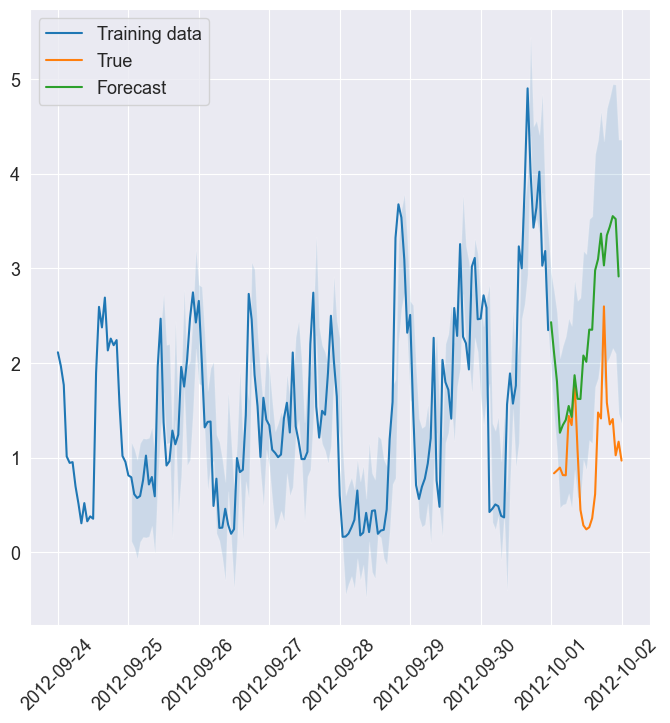

In [186]:
nforecast = 24
forecast = sarimax_res.forecast(nforecast)
predict = sarimax_res.get_prediction(end=sarimax.nobs + nforecast)
predict_ci = predict.conf_int(alpha=0.5)
fig, ax = plt.subplots(1, 1)
ax.plot(first_household[-nforecast*7:], label="Training data")
ax.plot(five_households.iloc[train_end+1:train_end+25, 0:1], label="True")
ax.plot(forecast, label="Forecast")
ax.fill_between(predict_ci.index[-nforecast*7:], predict_ci.iloc[-nforecast*7:, 0], predict_ci.iloc[-nforecast*7:, 1], alpha=0.15)
plt.legend()
ax.tick_params(axis='x', labelrotation=45)
fig.savefig(f"../figures/sarimax_{order}_{seasonal_order}.pdf")

In [95]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 24
predict = sarimax_res.get_prediction(end=sarimax.nobs + nforecast)
len(predict.predicted_mean)


6601

In [ ]:
p_full, q_full = np.unravel_index(aic_full.values.argmin(), aic_full.shape)
print("Best ARMA(p,q) model:", p_full, q_full)

In [123]:
# AIC values for all five households, looking into 6x6 different models
best_models = []
# Iterate over all five households
for i in range(5):
    aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
    arima_aic(five_households.iloc[3000:3000+train_set, i:i+1], aic_full)
    # Find the ARMA(p,q) model with the lowest AIC
    print("Household", i+1)
    print(aic_full)
    p_full, q_full = np.unravel_index(aic_full.values.argmin(), aic_full.shape)
    print("Best ARMA(p,q) model:", p_full, q_full)
    best_models.append((p_full, q_full))


Household 1
0       0.000000
1   -2621.841348
2   -2661.291938
3   -2664.062618
4   -2679.770406
5   -2687.388455
Name: 0, dtype: float64
Best ARMA(p,q) model: 2 4
Household 2
0    -3653.918667
1    -3653.427066
2    -3736.117686
3    48268.301567
4    41956.802893
5    31455.993007
Name: 1, dtype: float64
Best ARMA(p,q) model: 5 5
Household 3
0    125.480160
1    123.187811
2    121.002522
3    117.969301
4    115.189217
5    115.138981
Name: 2, dtype: float64
Best ARMA(p,q) model: 0 0
Household 4
0    10.0
1    12.0
2    14.0
3    16.0
4    18.0
5    20.0
Name: 3, dtype: float64
Best ARMA(p,q) model: 1 0
Household 5
0    12.0
1    14.0
2    16.0
3    18.0
4    20.0
5    22.0
Name: 4, dtype: float64
Best ARMA(p,q) model: 1 0


In [ ]:

# ARIMA model for household 1
st1 = STL(five_households[:train_set, 0], seasonal=1)
res = st1.fit()
fig = res.plot()


# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[1])


## Compute the ARIMA model that can handle missing data for a subset of the nodes

For each node we compare several ARIMA models based on the AIC, a information criterion to select models.
We then analyse if the majority of nodes would lead to the same ARIMA model (same order).

In [ ]:

# ARIMA model for household 2

# ARIMA model for household 3

# ARIMA model for household 4

# ARIMA model for household 5
